# Time Series Forecasting System
Time Series is a big component of our everyday lives. They are in fact used in medicine (EEG analysis), finance (Stock Prices) and electronics (Sensor Data Analysis). Many Machine Learning models have been created in order to tackle these types of tasks, two examples are ARIMA (AutoRegressive Integrated Moving Average) models and RNNs (Recurrent Neural Networks).


# Data Source

For Time series analysis, we are going to deal with Stock market Analysis. This dataset is based US-based stocks daily price and volume data.
Dataset taken for analysis is IBM stock market data from 2006-01-01 to 2018-01-01.

Below are the key fields in the dataset:

__`Date, Open, High, Low, Close, Volume, Name`__

# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Data

In [ ]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv.zip")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [ ]:
print(df.shape)
print(df.columns)

(3020, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')


In [ ]:
# Cleaning up the data
df.isnull().values.any()
df = df.dropna()
df.shape

(3019, 7)

In [ ]:
df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


# Note
This dataset is composed of different features.We will just examine the “Open” stock prices feature. This same analysis can be repeated for most of the other features.

# Visualization

### Visualizing the High and Low prices of IBM

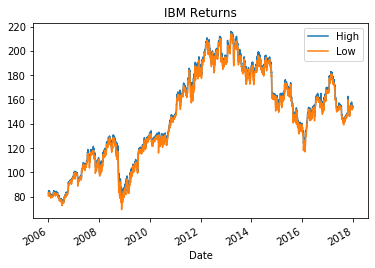

In [ ]:
dr = df[['High', 'Low']]
dr.plot()
plt.title('IBM Returns');

### Q1: Visualize the Open and Close prices of IBM

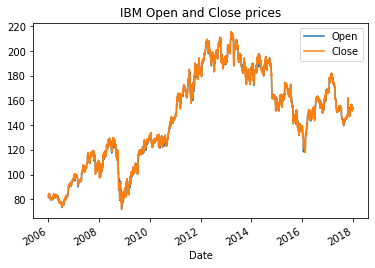

In [ ]:
dr = df[['Open', 'Close']]
dr.plot()
plt.title('IBM Open and Close prices');

### Q2: Visualize the Open and Close Cumulative Prices of IBM

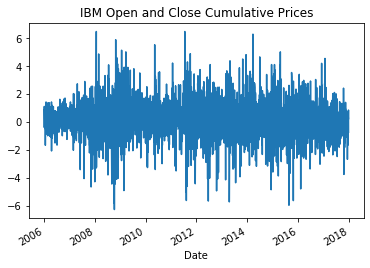

In [ ]:
# Cumulative price: Close - Open
df['Cumulative price'] = df['Close'] - df['Open']
df['Cumulative price'].plot();
plt.title('IBM Open and Close Cumulative Prices');

####  Before we start working on Time Series forecasting, Let's analyse the autocorrelation plot of the “Open” feature with respect to a few lag values

### Auto-correlation plot with Lag 1

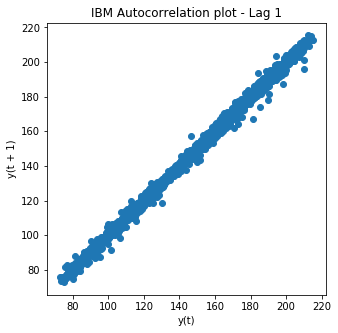

In [ ]:
# START_CODE_HERE - plot the Autocorrelation plot for feature 'Open'
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(df['Open'], lag=1)
plt.title('IBM Autocorrelation plot - Lag 1');
# END_CODE_HERE

### Q3: Visualize the Auto-Correlation plot for IBM Open prices with Lag 5 

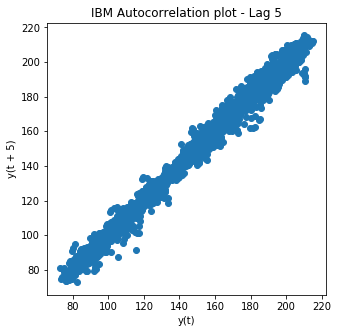

In [ ]:
plt.figure(figsize=(5,5))
lag_plot(df['Open'], lag=5)
plt.title('IBM Autocorrelation plot - Lag 5');

We see a definite linear trend in the auto-correlation plot telling us there is some correlation in prices with respect to prices from previous 1 / 5 days of lag which sets up the stage of forecasting future prices based on past price data 

## Build Train-Test Datasets

#### Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [ ]:
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]

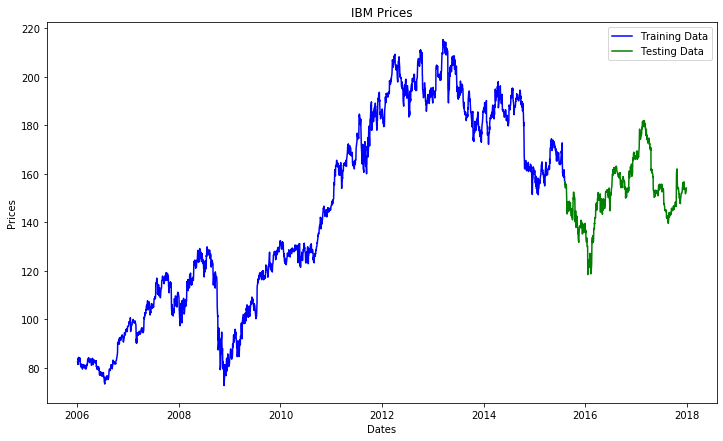

In [ ]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

# ARIMA (AutoRegressive Integrated Moving Average)

The acronym of ARIMA stands for:

AutoRegressive(AR) = the model takes advantage of the connection between a predefined number of lagged observations and the current one.

Integrated(I) = differencing between raw observations (eg. subtracting observations at different time steps).

Moving Average(MA) = the model takes advantage of the relationship between the residual error and the observations.

The ARIMA model makes use of three main parameters (p,d,q). These are:

p = number of lag observations.

d = the degree of differencing.

q = the size of the moving average window.



## Understaning the ARIMA Model

### the ARIMA parameters - used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q. You have already learnt a fair bit of this in the curriculum but following is a brief refresher.

__p:__ is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.

__d:__ is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. You can imagine an example of this as forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.

__q:__ is the parameter associated with the moving average part of the model.

### Approach to determine the parameters
There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc.

Another approach is to perform a grid search over multiple values of p,d,q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.


In this exercise, we will look into the statistical method of getting these values from auto-correlation and correlation plots.

### Stationarity of the data - Determine the d value

Stationarity typically indicates various statistical measures of the time series do not change over time. Thus, a time series is stationary when its mean, variance and auto-correlation, etc., are constant over time. 

Most time-series forecasting models typically perform well when the series is stationary and hence it is important to find out if your time-series dataset is stationary. 

ARIMAs that include differencing (i.e., d > 0) assume that the data becomes stationary after differencing. This is called difference-stationary. 

Auto-correlation plots are an easy way to determine whether your time series is sufficiently stationary for modeling. 

If the plot does not appear relatively stationary, your model will likely need a differencing term. 

The Augmented Dickey-Fuller test is an important statistical test which we will use to prove if the series is stationary or not and take necessary steps in case it is not stationary.

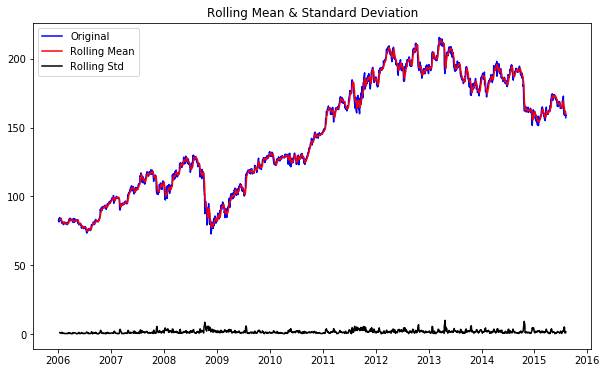

In [ ]:
window = 7
train_series = train_data['Open']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');
    

In [ ]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.487786
p-value                           0.539545
#Lags Used                        7.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

If the p-value is small beyond a specific significance level threshold, let's consider that to be a standard value of 0.05, then we can say the series is stationary. F

rom the above statistics, we can observe that the p-value is 0.539 which proves that our series is not stationary.

To get stationary data, there are many techniques. We can use log, differencing and so on. Let's use a first order differencing here.

### Q4: Apply a first order differencing on the training data

Hint: Check out the __`diff()`__ function in pandas and try using it on the __`train_series`__ dataset

In [ ]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)
train_diff.head()

Date
2006-01-04   -0.25
2006-01-05   -0.80
2006-01-06    2.55
2006-01-09    0.15
2006-01-10   -0.95
Name: Open, dtype: float64

### Q5: Visualize Rolling statistics for differenced train data

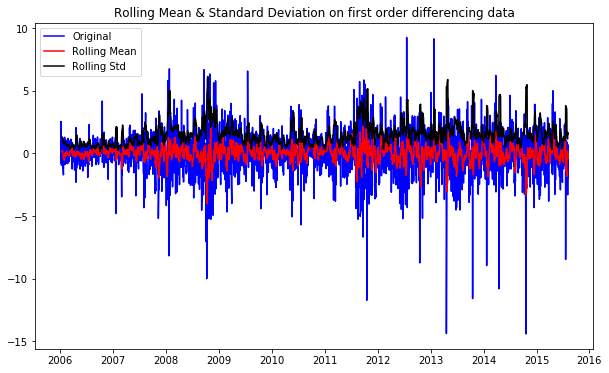

In [ ]:
#Determing rolling statistics
diff_rolmean = train_diff.rolling(window).mean()
diff_rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
diff_orig = plt.plot(train_diff, color='blue',label='Original')
diff_mean = plt.plot(diff_rolmean, color='red', label='Rolling Mean')
diff_std = plt.plot(diff_rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation on first order differencing data');

### Q6: Compute AD-Fuller Stats for differenced train data

In [ ]:
diff_dftest = adfuller(train_diff, autolag='AIC')
diff_dfoutput = pd.Series(diff_dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in diff_dftest[4].items():
    diff_dfoutput['Critical Value (%s)'%key] = value
diff_dfoutput

Test Statistic                  -20.324277
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

### ACF Plots (Auto Correlation Function):
ACF is an auto-correlation function which gives us correlation of any series with its lagged values(previous timestep values).

ACF plot describes the correlation of the current value with the previous lagged values(specified by *lags*).

For example, how the dependency chain is followed as direct dependency .... $S_{t-2} --> S_{t-1} --> S_t$*

Also, ACF finds correlation between $S_{t-2} --> S_t$ (indirect dependency).

* --> = represents dependency

#### Limitation: 
ACF is not very accurate as indirect dependency is affected by direct dependency and so the plots are always above the confidence band(as shown below).

### PACF Plots: Pearson Auto Correlation Function:
PACF plots models the indirect dependencies and is not affected by the direct dependencies.

$S_{t-2} --> S_t$

From the below example we can see how today's value is affected by the last 10 days. 

The points that lie inside the blue confidence band do not correlate with or affect today's value. In ACF, we saw that all values are above the confidence band(as $S_{t-2} --> S{t}$ is affected by $S_{t-1} --> S_t$), which is not a good representation of the correlation.


In PACF, indirect dependencies are modelled well.

## ACF and PACF - AR and MA Intuition
The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

### Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

### Plot ACF and PACF on the original train series

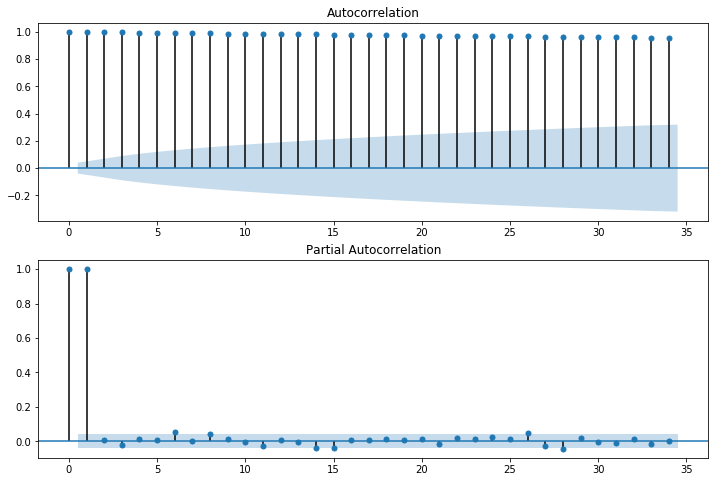

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

### Q7: Plot ACF and PACF on the differenced train series

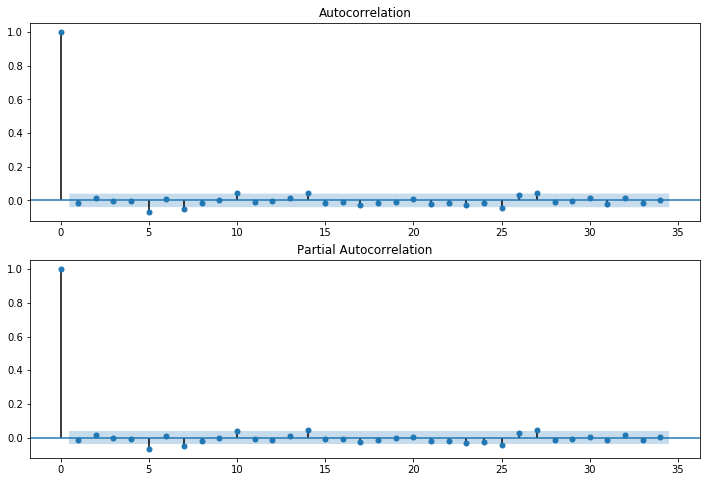

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); 
plot_pacf(train_diff, ax=ax[1]);

# How to determine p, d, q

It's easy to determine d. In our case, we see the first order differencing make the ts stationary. Hence d = 1

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 5 lags the AR is significant. Which means, we can use AR = 5 i.e, p = 5

To avoid the potential for incorrectly specifying the MA order to be too high we set MA = 0 i.e q = 0 by taking a look at the ACF plot though we do have a value of 5 which is significant considering the interval but we start off with the first lag value i.e q = 0.

Hence:

- p=5
- d=1
- q=0

# Evaluation of ARIMA Model

In order to evaluate the ARIMA model,we can use two different error functions:

- Mean Squared Error (MSE)
- Symmetric Mean Absolute Percentage Error (SMAPE)

SMAPE is commonly used as an accuracy measure based on relative errors

### SMAPE

![](imgs/smape.png)

SMAPE is not currently supported in Scikit-learn as a loss function, therefore we first create this function.

In [ ]:
def smape_kun(y_true, y_pred):
    # START_CODE_HERE
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    # END_CODE_HERE

### Q8: Difference the Test Series

In [ ]:
test_series = test_data['Open']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
test_diff.head()

Date
2015-08-10    0.88
2015-08-11   -0.81
2015-08-12   -1.70
2015-08-13    1.80
2015-08-14   -1.06
Name: Open, dtype: float64

### Q9: Train and Forecast using ARIMA Model by filling in the necessary blocks

Note: Here we will use a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model.
Of course this is not the only way for forecasting and you can do it in multiple ways e.g just use train data to forecast, use a window of days to forecast including test data and so on.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
%%time 

history = [x for x in train_diff]
tmp_params = (5,1,0)

predictions = list()
for t in range(len(test_diff)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    # initialize the model with history and right order of parameters
    model = ARIMA(history,order=tmp_params)
    # fit the model
    model_fit = model.fit()
    # END_CODE_HERE

    # use forecast on the fitted model
    output = model_fit.forecast()
    # yhat = output[0][0]
    yhat = output[0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=[-0.52443691], Expected=0.8800000000000239


Test Series Point: 100	Predicted=[0.50558671], Expected=-0.5100000000000193


/opt/conda/envs/springboard/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test Series Point: 200	Predicted=[0.03541799], Expected=2.0500000000000114


Test Series Point: 300	Predicted=[-0.37919126], Expected=-0.020000000000010232


Test Series Point: 400	Predicted=[-0.7068807], Expected=-0.36000000000001364


Test Series Point: 500	Predicted=[-0.29693828], Expected=0.5699999999999932


Test Series Point: 600	Predicted=[-0.22481553], Expected=0.4399999999999977


CPU times: user 6min 43s, sys: 28.8 s, total: 7min 12s
Wall time: 6min 30s


### Reverse Transform the forecasted values

This is very important. Since we used differencing of the first order in the series before training, we need to reverse transform the values to get meaningful price forecasts.

In [ ]:
#arr = np.array(predictions)
#a= np.row_stack((test_series.iloc[0], predictions))

In [ ]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
#reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_predictions = np.row_stack((test_series.iloc[0], predictions)).cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((604,), (604,))

### Evaluate model performance

In [ ]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 18.258
Symmetric Mean absolute percentage error: 2.445


The loss results for this model are available above. According to the MSE, the model loss is quite low but for SMAPE is instead consistently higher. One of the main reason for this discrepancy is because SMAPE is commonly used loss a loss function for Time Series problems and can, therefore, provide a more reliable analysis. That showed there is still room for improvement of our model.

## Let's Visualize the forecast results

In [ ]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

### Visualizing train, test and forecast prices

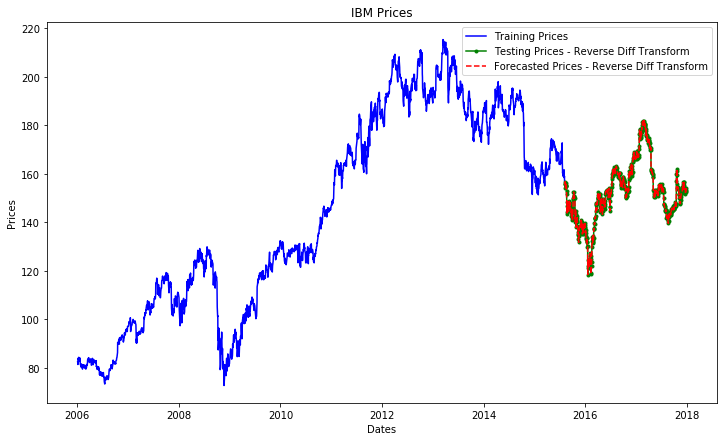

In [ ]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
#plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

### Q10: Visualize only test and forecast prices

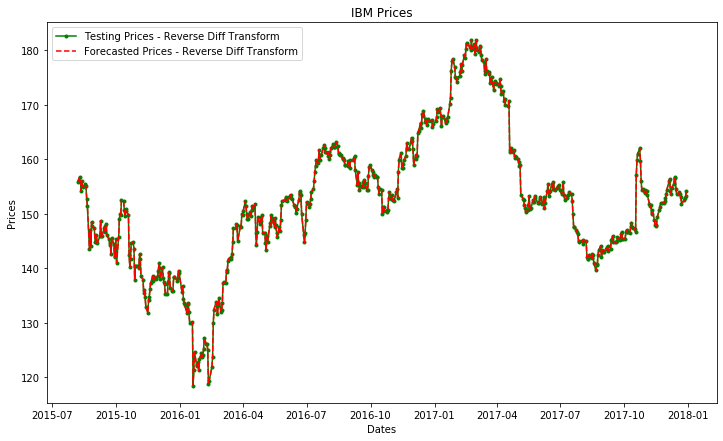

In [ ]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

This analysis using ARIMA has performed pretty well in forecasting prices 

# Time Series Forecasting with Deep Learning

The approach uses sequential models, to be more specific - LSTMs, to build a deep learning model that predicts the 'Open' Stock prices of IBM over a period of two years by using data from the previous 10 years.

### LSTM: A brief overview

What are LSTMs? : https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

### Headers

In [ ]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

# %tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

### Load Data

In [ ]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv")
df.isnull().values.any()
df = df.dropna()

df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


# Note
This dataset is composed of different features.we will just examine the "Open" stock prices feature. This same analysis can be repeated for most of the other features.

## Build Train-Test Datasets

In [ ]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_series.shape, test_series.shape

((2415,), (604,))

### Q11: Visualize train and test price data

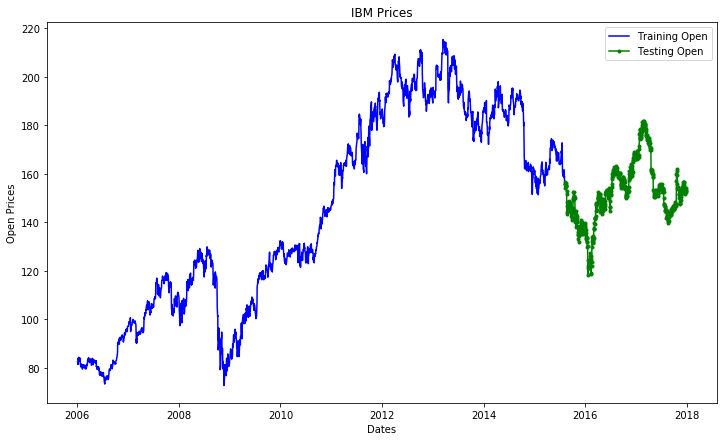

In [ ]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(train_series, color='blue', label='Training Open')
plt.plot(test_series, color='green', marker='.', label='Testing Open')
plt.legend();

### Scaling
As stock prices can vary across a wide range, we scale the data to have zero mean and unit variance.

This is done to ensure that the gradient descent is sooner when learning a deep learning model

### Q12: Use the initialized min-max scaler to scale the prices in train_series

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
# START_CODE_HERE
training_set_scaled = sc.fit_transform(pd.DataFrame(train_series))
# END_CODE_HERE

In [ ]:
training_set_scaled.shape

(2415, 1)

### Train Data Preparation

Train data uses the previous 60 days (two months) data to predict the stock price of the next day.
The data is prepared just like a sliding window approach, where
*window_size = 60*

Sample image for sliding window:
![Sliding window](imgs/sliding_window.png)

In [ ]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2355, 60), (2355,))

#### Reshape X_train

Now we reshape X_train in the format like:

(batch_size, timesteps, input_dim) => (m, features, $x_{i1}$)

The X_train should be now: (2709, 60, 1)

60 features = 60 day sliding window

$x_{i1}$ = 1 data point for each feature and i represents the feature



In [ ]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [ ]:
X_train.shape

(2355, 60, 1)

### LSTM Regression model

We use  [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):
*   units - output dimensions
*   return_sequences is set to True to get all the hidden state vectors information

The model uses 2 LSTM layers followed by a Dense Layer with a single neuron to output regression prediction.

#### Similar Model Architecture (dimensions not exact)

![Similar Model Architecture](imgs/lstm.png)


### Q13: Build the LSTM based forecasting DL Model architecture

Hints:

    - Fill the second LSTM layer using an LSTM cell with 64 units, remember NOT to set return_sequences to True as we are only concerned about passing the last sequence output to the next layer
    - Fill the Output layer with 1 unit
    - Compile the model with mentioned optimizer and loss values

In [ ]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1],1)))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [ ]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2119 samples, validate on 236 samples
Epoch 1/15


  64/2119 [..............................] - ETA: 53s - loss: 0.0032

 128/2119 [>.............................] - ETA: 27s - loss: 0.0019

 192/2119 [=>............................] - ETA: 19s - loss: 0.0037

 256/2119 [==>...........................] - ETA: 14s - loss: 0.0029

 320/2119 [===>..........................] - ETA: 12s - loss: 0.0027

 384/2119 [====>.........................] - ETA: 10s - loss: 0.0052

 448/2119 [=====>........................] - ETA: 8s - loss: 0.0049 

 512/2119 [======>.......................] - ETA: 7s - loss: 0.0050

 576/2119 [=======>......................] - ETA: 6s - loss: 0.0045

 640/2119 [========>.....................] - ETA: 6s - loss: 0.0048

 704/2119 [========>.....................] - ETA: 5s - loss: 0.0046

 768/2119 [=========>....................] - ETA: 5s - loss: 0.0043

 832/2119 [==========>...................] - ETA: 4s - loss: 0.0042

 896/2119 [===========>..................] - ETA: 4s - loss: 0.0043

 960/2119 [============>.................] - ETA: 4s - loss: 0.0040

1024/2119 [=============>................] - ETA: 3s - loss: 0.0038

1088/2119 [==============>...............] - ETA: 3s - loss: 0.0036

1152/2119 [===============>..............] - ETA: 3s - loss: 0.0036

1216/2119 [================>.............] - ETA: 2s - loss: 0.0037

1280/2119 [=================>............] - ETA: 2s - loss: 0.0057

1344/2119 [==================>...........] - ETA: 2s - loss: 0.0059

1408/2119 [==================>...........] - ETA: 2s - loss: 0.0070

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0069

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0073

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0090

1664/2119 [======================>.......] - ETA: 1s - loss: 0.0108

1728/2119 [=======================>......] - ETA: 1s - loss: 0.0104

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0101

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0099

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0096

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0093

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0091

2112/2119 [============================>.] - ETA: 0s - loss: 0.0089

2119/2119 [==============================] - 6s 3ms/sample - loss: 0.0089 - val_loss: 0.0084


Epoch 2/15
  64/2119 [..............................] - ETA: 3s - loss: 0.0273

 128/2119 [>.............................] - ETA: 4s - loss: 0.0199

 192/2119 [=>............................] - ETA: 3s - loss: 0.0146

 256/2119 [==>...........................] - ETA: 3s - loss: 0.0115

 320/2119 [===>..........................] - ETA: 3s - loss: 0.0093

 384/2119 [====>.........................] - ETA: 3s - loss: 0.0078

 448/2119 [=====>........................] - ETA: 3s - loss: 0.0068

 512/2119 [======>.......................] - ETA: 3s - loss: 0.0061

 576/2119 [=======>......................] - ETA: 3s - loss: 0.0055

 640/2119 [========>.....................] - ETA: 3s - loss: 0.0052

 704/2119 [========>.....................] - ETA: 3s - loss: 0.0051

 768/2119 [=========>....................] - ETA: 2s - loss: 0.0047

 832/2119 [==========>...................] - ETA: 2s - loss: 0.0044

 896/2119 [===========>..................] - ETA: 2s - loss: 0.0042

 960/2119 [============>.................] - ETA: 2s - loss: 0.0039

1024/2119 [=============>................] - ETA: 2s - loss: 0.0037

1088/2119 [==============>...............] - ETA: 2s - loss: 0.0035

1152/2119 [===============>..............] - ETA: 2s - loss: 0.0034

1216/2119 [================>.............] - ETA: 1s - loss: 0.0032

1280/2119 [=================>............] - ETA: 1s - loss: 0.0031

1344/2119 [==================>...........] - ETA: 1s - loss: 0.0030

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0030

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0029

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0032

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0095

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0105

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0103

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0101

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0098

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0095

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0093

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0090

2112/2119 [============================>.] - ETA: 0s - loss: 0.0088

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0087 - val_loss: 0.0027


Epoch 3/15
  64/2119 [..............................] - ETA: 6s - loss: 0.0090

 128/2119 [>.............................] - ETA: 5s - loss: 0.0066

 192/2119 [=>............................] - ETA: 4s - loss: 0.0048

 256/2119 [==>...........................] - ETA: 4s - loss: 0.0039

 320/2119 [===>..........................] - ETA: 3s - loss: 0.0032

 384/2119 [====>.........................] - ETA: 3s - loss: 0.0027

 448/2119 [=====>........................] - ETA: 3s - loss: 0.0025

 512/2119 [======>.......................] - ETA: 3s - loss: 0.0022

 576/2119 [=======>......................] - ETA: 3s - loss: 0.0020

 640/2119 [========>.....................] - ETA: 3s - loss: 0.0021

 704/2119 [========>.....................] - ETA: 3s - loss: 0.0021

 768/2119 [=========>....................] - ETA: 2s - loss: 0.0020

 832/2119 [==========>...................] - ETA: 2s - loss: 0.0018

 896/2119 [===========>..................] - ETA: 2s - loss: 0.0018

 960/2119 [============>.................] - ETA: 2s - loss: 0.0017

1024/2119 [=============>................] - ETA: 2s - loss: 0.0016

1088/2119 [==============>...............] - ETA: 2s - loss: 0.0015

1152/2119 [===============>..............] - ETA: 2s - loss: 0.0015

1216/2119 [================>.............] - ETA: 2s - loss: 0.0014

1280/2119 [=================>............] - ETA: 1s - loss: 0.0014

1344/2119 [==================>...........] - ETA: 1s - loss: 0.0014

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0015

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0016

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0022

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0040

1664/2119 [======================>.......] - ETA: 1s - loss: 0.0041

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0042

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0043

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0043

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0044

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0044

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0043

2112/2119 [============================>.] - ETA: 0s - loss: 0.0042

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0042 - val_loss: 0.0017


Epoch 4/15


  64/2119 [..............................] - ETA: 4s - loss: 0.0051

 128/2119 [>.............................] - ETA: 4s - loss: 0.0032

 192/2119 [=>............................] - ETA: 4s - loss: 0.0022

 256/2119 [==>...........................] - ETA: 4s - loss: 0.0018

 320/2119 [===>..........................] - ETA: 4s - loss: 0.0015

 384/2119 [====>.........................] - ETA: 3s - loss: 0.0013

 448/2119 [=====>........................] - ETA: 3s - loss: 0.0013

 512/2119 [======>.......................] - ETA: 3s - loss: 0.0012

 576/2119 [=======>......................] - ETA: 3s - loss: 0.0011

 640/2119 [========>.....................] - ETA: 3s - loss: 0.0012

 704/2119 [========>.....................] - ETA: 3s - loss: 0.0013

 768/2119 [=========>....................] - ETA: 2s - loss: 0.0012

 832/2119 [==========>...................] - ETA: 2s - loss: 0.0012

 896/2119 [===========>..................] - ETA: 2s - loss: 0.0011

 960/2119 [============>.................] - ETA: 2s - loss: 0.0011

1024/2119 [=============>................] - ETA: 2s - loss: 0.0010

1088/2119 [==============>...............] - ETA: 2s - loss: 0.0010

1152/2119 [===============>..............] - ETA: 2s - loss: 9.8307e-04

1216/2119 [================>.............] - ETA: 1s - loss: 9.6493e-04

1280/2119 [=================>............] - ETA: 1s - loss: 9.7880e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 0.0012    

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0025

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0031

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0050

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0053

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0057

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0057

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0057

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0057

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0056

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0054

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0053

2112/2119 [============================>.] - ETA: 0s - loss: 0.0052

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0052 - val_loss: 0.0039


Epoch 5/15


  64/2119 [..............................] - ETA: 3s - loss: 0.0046

 128/2119 [>.............................] - ETA: 3s - loss: 0.0028

 192/2119 [=>............................] - ETA: 3s - loss: 0.0020

 256/2119 [==>...........................] - ETA: 3s - loss: 0.0016

 320/2119 [===>..........................] - ETA: 3s - loss: 0.0013

 384/2119 [====>.........................] - ETA: 3s - loss: 0.0012

 448/2119 [=====>........................] - ETA: 3s - loss: 0.0012

 512/2119 [======>.......................] - ETA: 3s - loss: 0.0011

 576/2119 [=======>......................] - ETA: 2s - loss: 0.0010

 640/2119 [========>.....................] - ETA: 2s - loss: 0.0012

 704/2119 [========>.....................] - ETA: 2s - loss: 0.0012

 768/2119 [=========>....................] - ETA: 2s - loss: 0.0012

 832/2119 [==========>...................] - ETA: 2s - loss: 0.0011

 896/2119 [===========>..................] - ETA: 2s - loss: 0.0011

 960/2119 [============>.................] - ETA: 2s - loss: 0.0010

1024/2119 [=============>................] - ETA: 2s - loss: 9.7900e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 9.5169e-04

1152/2119 [===============>..............] - ETA: 1s - loss: 9.3340e-04

1216/2119 [================>.............] - ETA: 1s - loss: 9.1531e-04

1280/2119 [=================>............] - ETA: 1s - loss: 9.1376e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 9.7076e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0015    

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0029

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0051

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0050

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0050

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0049

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0049

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0049

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0048

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0047

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0046

2112/2119 [============================>.] - ETA: 0s - loss: 0.0045

2119/2119 [==============================] - 4s 2ms/sample - loss: 0.0045 - val_loss: 0.0092


Epoch 6/15


  64/2119 [..............................] - ETA: 4s - loss: 0.0039

 128/2119 [>.............................] - ETA: 4s - loss: 0.0022

 192/2119 [=>............................] - ETA: 3s - loss: 0.0016

 256/2119 [==>...........................] - ETA: 3s - loss: 0.0013

 320/2119 [===>..........................] - ETA: 3s - loss: 0.0011

 384/2119 [====>.........................] - ETA: 3s - loss: 0.0010

 448/2119 [=====>........................] - ETA: 3s - loss: 0.0010

 512/2119 [======>.......................] - ETA: 3s - loss: 0.0010

 576/2119 [=======>......................] - ETA: 3s - loss: 9.7830e-04

 640/2119 [========>.....................] - ETA: 2s - loss: 0.0011    

 704/2119 [========>.....................] - ETA: 2s - loss: 0.0011

 768/2119 [=========>....................] - ETA: 2s - loss: 0.0011

 832/2119 [==========>...................] - ETA: 2s - loss: 0.0011

 896/2119 [===========>..................] - ETA: 2s - loss: 0.0010

 960/2119 [============>.................] - ETA: 2s - loss: 9.7904e-04

1024/2119 [=============>................] - ETA: 2s - loss: 9.3107e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 9.0287e-04

1152/2119 [===============>..............] - ETA: 1s - loss: 8.8753e-04

1216/2119 [================>.............] - ETA: 1s - loss: 8.5850e-04

1280/2119 [=================>............] - ETA: 1s - loss: 8.6843e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 8.9059e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0011    

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0023

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0046

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0047

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0047

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0046

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0046

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0046

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0045

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0044

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0043

2112/2119 [============================>.] - ETA: 0s - loss: 0.0042

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0042 - val_loss: 0.0075


Epoch 7/15
  64/2119 [..............................] - ETA: 4s - loss: 0.0022

 128/2119 [>.............................] - ETA: 4s - loss: 0.0012

 192/2119 [=>............................] - ETA: 3s - loss: 8.6355e-04

 256/2119 [==>...........................] - ETA: 3s - loss: 8.1079e-04

 320/2119 [===>..........................] - ETA: 3s - loss: 7.0301e-04

 384/2119 [====>.........................] - ETA: 3s - loss: 6.4655e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 7.1323e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 7.4542e-04

 576/2119 [=======>......................] - ETA: 3s - loss: 7.2441e-04

 640/2119 [========>.....................] - ETA: 3s - loss: 8.5727e-04

 704/2119 [========>.....................] - ETA: 2s - loss: 9.3330e-04

 768/2119 [=========>....................] - ETA: 2s - loss: 9.3225e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 8.9839e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 8.7476e-04

 960/2119 [============>.................] - ETA: 2s - loss: 8.4089e-04

1024/2119 [=============>................] - ETA: 2s - loss: 8.0646e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 7.9079e-04

1152/2119 [===============>..............] - ETA: 2s - loss: 7.7132e-04

1216/2119 [================>.............] - ETA: 1s - loss: 7.6414e-04

1280/2119 [=================>............] - ETA: 1s - loss: 7.9987e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 0.0010    

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0020

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0025

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0038

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0043

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0047

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0046

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0046

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0046

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0045

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0044

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0043

2112/2119 [============================>.] - ETA: 0s - loss: 0.0042

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0042 - val_loss: 0.0051


Epoch 8/15
  64/2119 [..............................] - ETA: 3s - loss: 0.0020

 128/2119 [>.............................] - ETA: 4s - loss: 0.0011

 192/2119 [=>............................] - ETA: 4s - loss: 7.8005e-04

 256/2119 [==>...........................] - ETA: 4s - loss: 7.2075e-04

 320/2119 [===>..........................] - ETA: 3s - loss: 6.3342e-04

 384/2119 [====>.........................] - ETA: 3s - loss: 5.9069e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 6.3813e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 6.5004e-04

 576/2119 [=======>......................] - ETA: 3s - loss: 6.3740e-04

 640/2119 [========>.....................] - ETA: 3s - loss: 7.6249e-04

 704/2119 [========>.....................] - ETA: 3s - loss: 8.3142e-04

 768/2119 [=========>....................] - ETA: 2s - loss: 8.4392e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 8.1548e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 7.9617e-04

 960/2119 [============>.................] - ETA: 2s - loss: 7.7399e-04

1024/2119 [=============>................] - ETA: 2s - loss: 7.4376e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 7.2143e-04

1152/2119 [===============>..............] - ETA: 2s - loss: 7.0634e-04

1216/2119 [================>.............] - ETA: 2s - loss: 6.9977e-04

1280/2119 [=================>............] - ETA: 1s - loss: 7.2382e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 7.4925e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 8.6644e-04

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0014    

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0036

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0039

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0042

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0042

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0042

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0043

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0042

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0041

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0040

2112/2119 [============================>.] - ETA: 0s - loss: 0.0039

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0039 - val_loss: 0.0026


Epoch 9/15


  64/2119 [..............................] - ETA: 4s - loss: 0.0013

 128/2119 [>.............................] - ETA: 4s - loss: 7.0325e-04

 192/2119 [=>............................] - ETA: 4s - loss: 5.1938e-04

 256/2119 [==>...........................] - ETA: 4s - loss: 5.1361e-04

 320/2119 [===>..........................] - ETA: 4s - loss: 4.6519e-04

 384/2119 [====>.........................] - ETA: 3s - loss: 4.5134e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 5.3563e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 5.6791e-04

 576/2119 [=======>......................] - ETA: 3s - loss: 5.5944e-04

 640/2119 [========>.....................] - ETA: 3s - loss: 6.8402e-04

 704/2119 [========>.....................] - ETA: 3s - loss: 7.4503e-04

 768/2119 [=========>....................] - ETA: 3s - loss: 7.5215e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 7.2690e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 7.0965e-04

 960/2119 [============>.................] - ETA: 2s - loss: 6.8146e-04

1024/2119 [=============>................] - ETA: 2s - loss: 6.5195e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 6.4245e-04

1152/2119 [===============>..............] - ETA: 2s - loss: 6.2760e-04

1216/2119 [================>.............] - ETA: 2s - loss: 6.1525e-04

1280/2119 [=================>............] - ETA: 1s - loss: 6.1092e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 6.4331e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 8.8937e-04

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0020    

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0038

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0038

1664/2119 [======================>.......] - ETA: 1s - loss: 0.0039

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0039

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0039

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0039

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0038

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0037

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0037

2112/2119 [============================>.] - ETA: 0s - loss: 0.0036

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0036 - val_loss: 0.0059


Epoch 10/15


  64/2119 [..............................] - ETA: 4s - loss: 0.0019

 128/2119 [>.............................] - ETA: 3s - loss: 0.0010

 192/2119 [=>............................] - ETA: 3s - loss: 7.6231e-04

 256/2119 [==>...........................] - ETA: 3s - loss: 7.2277e-04

 320/2119 [===>..........................] - ETA: 3s - loss: 6.2551e-04

 384/2119 [====>.........................] - ETA: 3s - loss: 5.7572e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 6.2821e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 6.3874e-04

 576/2119 [=======>......................] - ETA: 3s - loss: 6.3733e-04

 640/2119 [========>.....................] - ETA: 2s - loss: 7.4207e-04

 704/2119 [========>.....................] - ETA: 2s - loss: 8.3183e-04

 768/2119 [=========>....................] - ETA: 2s - loss: 8.3073e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 8.0415e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 7.8497e-04

 960/2119 [============>.................] - ETA: 2s - loss: 7.5641e-04

1024/2119 [=============>................] - ETA: 2s - loss: 7.2433e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 7.0792e-04

1152/2119 [===============>..............] - ETA: 1s - loss: 6.8936e-04

1216/2119 [================>.............] - ETA: 1s - loss: 6.7259e-04

1280/2119 [=================>............] - ETA: 1s - loss: 6.6967e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 6.8938e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 8.1597e-04

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0017    

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0028

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0036

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0036

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0035

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0034

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0034

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0033

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0032

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0031

2112/2119 [============================>.] - ETA: 0s - loss: 0.0031

2119/2119 [==============================] - 4s 2ms/sample - loss: 0.0031 - val_loss: 0.0043


Epoch 11/15
  64/2119 [..............................] - ETA: 4s - loss: 0.0015

 128/2119 [>.............................] - ETA: 4s - loss: 7.9697e-04

 192/2119 [=>............................] - ETA: 3s - loss: 5.9842e-04

 256/2119 [==>...........................] - ETA: 3s - loss: 5.7565e-04

 320/2119 [===>..........................] - ETA: 4s - loss: 5.0881e-04

 384/2119 [====>.........................] - ETA: 4s - loss: 4.7785e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 5.3838e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 5.6620e-04

 576/2119 [=======>......................] - ETA: 3s - loss: 5.6585e-04

 640/2119 [========>.....................] - ETA: 3s - loss: 6.9195e-04

 704/2119 [========>.....................] - ETA: 3s - loss: 7.7095e-04

 768/2119 [=========>....................] - ETA: 3s - loss: 7.7521e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 7.5416e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 7.3676e-04

 960/2119 [============>.................] - ETA: 2s - loss: 7.0642e-04

1024/2119 [=============>................] - ETA: 2s - loss: 6.8171e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 6.6085e-04

1152/2119 [===============>..............] - ETA: 2s - loss: 6.4998e-04

1216/2119 [================>.............] - ETA: 1s - loss: 6.4530e-04

1280/2119 [=================>............] - ETA: 1s - loss: 6.7359e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 8.9042e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0019    

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0022

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0032

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0036

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0041

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0040

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0040

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0040

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0039

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0038

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0038

2112/2119 [============================>.] - ETA: 0s - loss: 0.0037

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0037 - val_loss: 0.0041


Epoch 12/15


  64/2119 [..............................] - ETA: 3s - loss: 0.0015

 128/2119 [>.............................] - ETA: 3s - loss: 8.1756e-04

 192/2119 [=>............................] - ETA: 3s - loss: 6.1129e-04

 256/2119 [==>...........................] - ETA: 3s - loss: 5.9539e-04

 320/2119 [===>..........................] - ETA: 3s - loss: 5.2495e-04

 384/2119 [====>.........................] - ETA: 3s - loss: 5.0625e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 5.6828e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 5.9899e-04

 576/2119 [=======>......................] - ETA: 2s - loss: 5.9796e-04

 640/2119 [========>.....................] - ETA: 2s - loss: 6.8841e-04

 704/2119 [========>.....................] - ETA: 2s - loss: 7.7379e-04

 768/2119 [=========>....................] - ETA: 2s - loss: 7.7316e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 7.4853e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 7.2924e-04

 960/2119 [============>.................] - ETA: 2s - loss: 6.9869e-04

1024/2119 [=============>................] - ETA: 2s - loss: 6.7068e-04

1088/2119 [==============>...............] - ETA: 1s - loss: 6.5614e-04

1152/2119 [===============>..............] - ETA: 1s - loss: 6.3435e-04

1216/2119 [================>.............] - ETA: 1s - loss: 6.2820e-04

1280/2119 [=================>............] - ETA: 1s - loss: 6.2457e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 6.4971e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 8.2846e-04

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0019    

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0023

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0028

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0028

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0028

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0028

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0027

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0027

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0026

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0026

2112/2119 [============================>.] - ETA: 0s - loss: 0.0025

2119/2119 [==============================] - 4s 2ms/sample - loss: 0.0025 - val_loss: 0.0011


Epoch 13/15


  64/2119 [..............................] - ETA: 7s - loss: 0.0010

 128/2119 [>.............................] - ETA: 5s - loss: 5.5574e-04

 192/2119 [=>............................] - ETA: 4s - loss: 4.1422e-04

 256/2119 [==>...........................] - ETA: 4s - loss: 4.1451e-04

 320/2119 [===>..........................] - ETA: 4s - loss: 3.7448e-04

 384/2119 [====>.........................] - ETA: 3s - loss: 3.6414e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 4.2863e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 4.6991e-04

 576/2119 [=======>......................] - ETA: 3s - loss: 4.7028e-04

 640/2119 [========>.....................] - ETA: 3s - loss: 5.9632e-04

 704/2119 [========>.....................] - ETA: 3s - loss: 6.4696e-04

 768/2119 [=========>....................] - ETA: 3s - loss: 6.5211e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 6.3322e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 6.2551e-04

 960/2119 [============>.................] - ETA: 2s - loss: 6.0548e-04

1024/2119 [=============>................] - ETA: 2s - loss: 5.8794e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 5.8281e-04

1152/2119 [===============>..............] - ETA: 2s - loss: 5.8126e-04

1216/2119 [================>.............] - ETA: 1s - loss: 5.7438e-04

1280/2119 [=================>............] - ETA: 1s - loss: 6.0986e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 7.8394e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0017    

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0019

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0027

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0032

1664/2119 [======================>.......] - ETA: 1s - loss: 0.0037

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0037

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0036

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0036

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0035

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0034

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0034

2112/2119 [============================>.] - ETA: 0s - loss: 0.0033

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0033 - val_loss: 0.0071


Epoch 14/15


  64/2119 [..............................] - ETA: 3s - loss: 0.0030

 128/2119 [>.............................] - ETA: 3s - loss: 0.0016

 192/2119 [=>............................] - ETA: 3s - loss: 0.0011

 256/2119 [==>...........................] - ETA: 3s - loss: 0.0010

 320/2119 [===>..........................] - ETA: 3s - loss: 8.6016e-04

 384/2119 [====>.........................] - ETA: 3s - loss: 7.9521e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 7.9774e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 7.9952e-04

 576/2119 [=======>......................] - ETA: 3s - loss: 8.0812e-04

 640/2119 [========>.....................] - ETA: 2s - loss: 8.7284e-04

 704/2119 [========>.....................] - ETA: 2s - loss: 9.6341e-04

 768/2119 [=========>....................] - ETA: 2s - loss: 9.3339e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 8.9969e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 8.7005e-04

 960/2119 [============>.................] - ETA: 2s - loss: 8.3360e-04

1024/2119 [=============>................] - ETA: 2s - loss: 7.9568e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 7.7674e-04

1152/2119 [===============>..............] - ETA: 1s - loss: 7.5609e-04

1216/2119 [================>.............] - ETA: 1s - loss: 7.4800e-04

1280/2119 [=================>............] - ETA: 1s - loss: 7.4807e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 8.3844e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 0.0013    

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0019

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0032

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0033

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0035

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0035

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0034

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0034

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0034

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0033

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0032

2112/2119 [============================>.] - ETA: 0s - loss: 0.0032

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0032 - val_loss: 0.0033


Epoch 15/15


  64/2119 [..............................] - ETA: 4s - loss: 0.0012

 128/2119 [>.............................] - ETA: 3s - loss: 6.4341e-04

 192/2119 [=>............................] - ETA: 3s - loss: 4.9252e-04

 256/2119 [==>...........................] - ETA: 3s - loss: 4.9347e-04

 320/2119 [===>..........................] - ETA: 3s - loss: 4.3785e-04

 384/2119 [====>.........................] - ETA: 3s - loss: 4.5060e-04

 448/2119 [=====>........................] - ETA: 3s - loss: 5.0993e-04

 512/2119 [======>.......................] - ETA: 3s - loss: 5.5671e-04

 576/2119 [=======>......................] - ETA: 3s - loss: 5.6582e-04

 640/2119 [========>.....................] - ETA: 2s - loss: 6.4800e-04

 704/2119 [========>.....................] - ETA: 2s - loss: 7.4841e-04

 768/2119 [=========>....................] - ETA: 2s - loss: 7.3538e-04

 832/2119 [==========>...................] - ETA: 2s - loss: 7.1526e-04

 896/2119 [===========>..................] - ETA: 2s - loss: 7.0032e-04

 960/2119 [============>.................] - ETA: 2s - loss: 6.7252e-04

1024/2119 [=============>................] - ETA: 2s - loss: 6.4378e-04

1088/2119 [==============>...............] - ETA: 2s - loss: 6.3462e-04

1152/2119 [===============>..............] - ETA: 2s - loss: 6.2699e-04

1216/2119 [================>.............] - ETA: 1s - loss: 6.0967e-04

1280/2119 [=================>............] - ETA: 1s - loss: 6.1413e-04

1344/2119 [==================>...........] - ETA: 1s - loss: 6.4240e-04

1408/2119 [==================>...........] - ETA: 1s - loss: 8.8912e-04

1472/2119 [===================>..........] - ETA: 1s - loss: 0.0016    

1536/2119 [====================>.........] - ETA: 1s - loss: 0.0029

1600/2119 [=====================>........] - ETA: 1s - loss: 0.0030

1664/2119 [======================>.......] - ETA: 0s - loss: 0.0031

1728/2119 [=======================>......] - ETA: 0s - loss: 0.0030

1792/2119 [========================>.....] - ETA: 0s - loss: 0.0031

1856/2119 [=========================>....] - ETA: 0s - loss: 0.0031

1920/2119 [==========================>...] - ETA: 0s - loss: 0.0030

1984/2119 [===========================>..] - ETA: 0s - loss: 0.0030

2048/2119 [===========================>..] - ETA: 0s - loss: 0.0030

2112/2119 [============================>.] - ETA: 0s - loss: 0.0029

2119/2119 [==============================] - 5s 2ms/sample - loss: 0.0029 - val_loss: 0.0092


### Test Data Forecasting

#### Data Preparation:
Lets prepare the test data just like we did with the train data.

Remember to start forecasting on the first day of the test data, we need the last 60 days of train data.

Thus, the following steps have been performed so first 60 entires of test set have 60 previous values from the train dataset

### Q14: Get the last 60 records from train_series

In [ ]:
train_last60 = train_series[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [ ]:
test_series.shape

(604,)

### Q15: Combine both train_last60 and test_series together 

Hint: Check pandas __`concat()`__

In [ ]:
new_test_series = pd.concat([train_last60,test_series])
print(new_test_series.shape)
assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(664,)


### Q16: Scale the test dataset (new_test_series) using the trained MinMaxScaler transformer - sc

Hint: Don't fit the scaler again here since it has already been trained

In [ ]:
test_set_scaled = sc.transform(pd.DataFrame(new_test_series))

### Prepare Test dataset Windows of 60  days each

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(604, 60, 1)

### Model Prediction and Reverse Transform of Prices

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
predicted_stock_price_revtrans_series.index = test_series.index
predicted_stock_price_revtrans_series.shape, test_series.shape

((604,), (604,))

## Model Evaluation

In [ ]:
# Evaluating our model
error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 179.813
Symmetric Mean absolute percentage error: 8.265


## Visualizing the results from model predictions

### Visualize train, test and forecasted prices

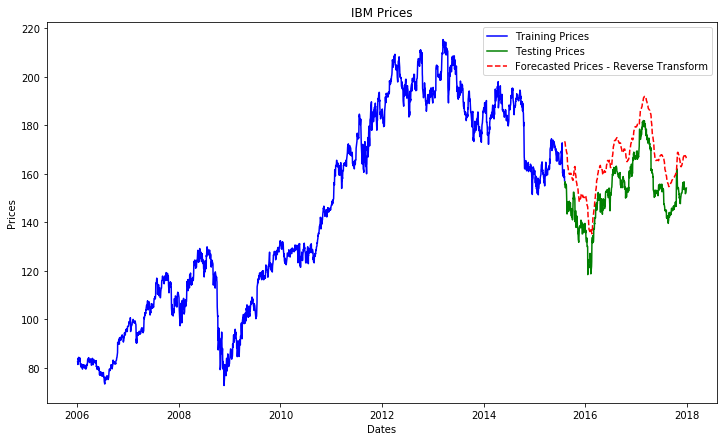

In [ ]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

### Q17: Visualize only test and forecast prices

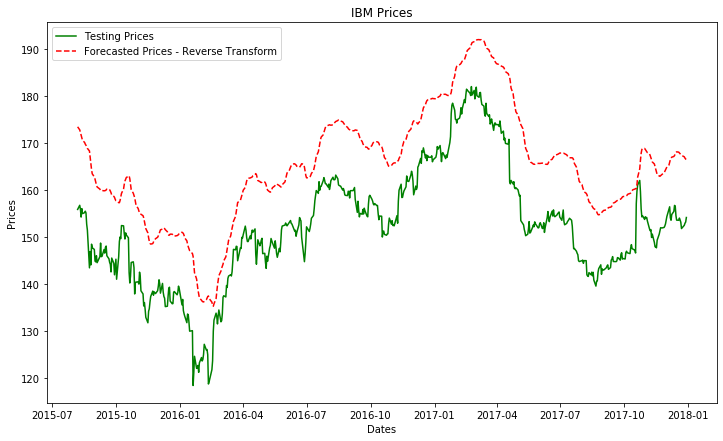

In [ ]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

# Conclusion

Remember we did a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model which gave it such good results vs. the LSTM model where we used 2 months of rolling window price data to predict the next day's price.